# CIR Model to simulate changes in interest rates and Liability Hedging


The Cox Ingersoll Ross (CIR) model is used to model the dynamics of interest rates, and is an extension of the popular *Vasicek Model* to prevent negative interest rates:

$$ dr_t = a(b - r_t)dt + \sigma\sqrt{r_t}dW_t $$

## Short Rate vs Annualized rate

In [1]:
# 1 year period
1 + 1*1

2

In [2]:
# twice a year --> 1 semester
1 + 1*0.5 + (1 + 1*0.5)*.5

2.25

In [3]:
# 4 time a year --> 1 quarter
1 + (1)*0.25 + (1 + (1)*0.25)*0.25 + (1 + (1)*0.25 + (1 + (1)*0.25)*0.25)*.25 + (1 + (1)*0.25 + (1 + (1)*0.25)*0.25 + (1 + (1)*0.25 + (1 + (1)*0.25)*0.25)*.25)*.25

2.44140625

In a general, if we compound ever 1/N of a year (i.e N times a year) we get:

$$ (1 + \frac{r}{N})^N $$

In [4]:
(1+1/2)**2

2.25

In [5]:
(1+1/4)**4

2.44140625

In [6]:
(1+1/100)**100

2.7048138294215285

In [7]:
(1+1/100000)**100000
# look like e

2.7182682371922975

As N becomes very large we get the generalization:

$$ 1 + r_{annual} = e^{r_{inst}} $$

i.e.

$$ r_{annual} = e^{r_{inst}} - 1$$

and 

$$ r_{inst} = ln(1 + r_{annual}) $$




In [8]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts short or instant rate to an annualized rate
    """
    # return np.exp(r)-1 #less efficient
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized rate to a short rate
    """
    # return np.log(1 + r) #less efficient
    return np.log1p(r)

$$ dr_t = a(b - r_t)dt + \sigma\sqrt{r_t}dW_t $$

In [9]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0 = None):
    """
    Implementation of the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0) #convertion of annualized to instant, similar for small value fo r
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)+1 # +1 for the initialization
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios)) #dW_t
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        # rates[step] = r_t + d_r_t original version but the second line make sure that no negative rate
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))


In [10]:
%matplotlib inline

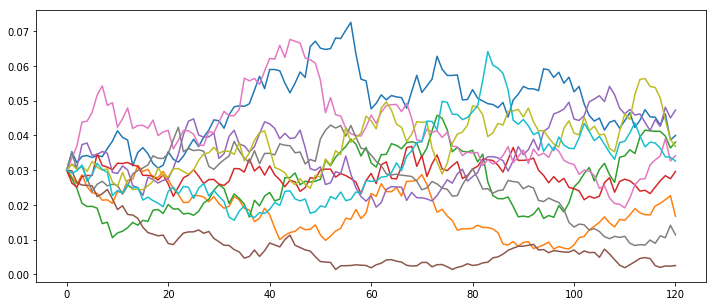

In [11]:
cir(n_scenarios=10).plot(figsize=(12,5), legend=False)

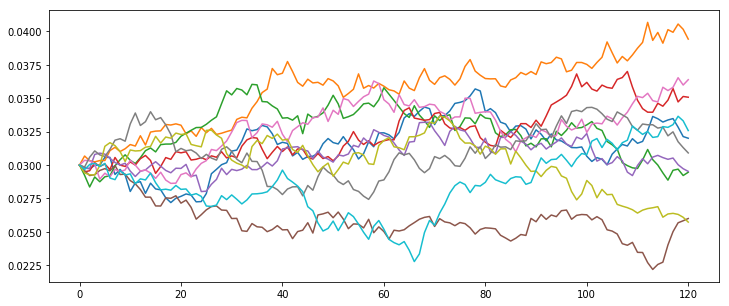

In [12]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [14]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(figsize=(12,5), legend=False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir, 
                              r_0 = (0, .15, .01), 
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100, 5),
                              )

display(controls)

A Jupyter Widget

In [15]:
import math

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0 = None):
    """
    Generate random interest rate evolutio over time using the CIR model
    b and r_0 are assumed to be annualized rate, not the short rate
    and the returned value are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0) #convertion of annualized to instant, similar for small value fo r
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # +1 for the initialization and int as n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios)) #dW_t
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## for Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####
    
    ## define Princing formula
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h + (h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
     
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        # rates[step] = r_t + d_r_t original version but the second line make sure that no negative rate
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])
    
    rates = pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))
    ### for prices
    prices = pd.DataFrame(data = prices, index = range(num_steps))
    ##
    return rates, prices


In [16]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(figsize=(12,5), legend=False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir_prices, 
                              r_0 = (0, .15, .01), 
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),

                               n_scenarios = (1, 100),
                              )

display(controls)

A Jupyter Widget

In [17]:
# use case
a_0 = .75 #asset today
rates, bond_prices = cir(r_0 = .03, b=.03, n_scenarios=10, n_years=10)
liabilities = bond_prices
zcbonsd_10 = pd.Series(data = [1], index=[10])
zc_0 = erk.pv(zcbonsd_10, r=0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0 * (1+rates/12).cumprod()

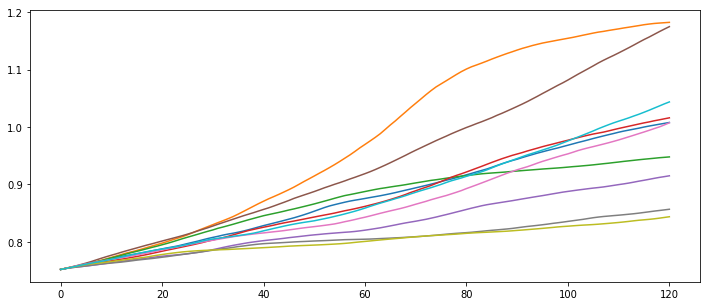

In [18]:
av_cash.plot(legend=False, figsize=(12,5))

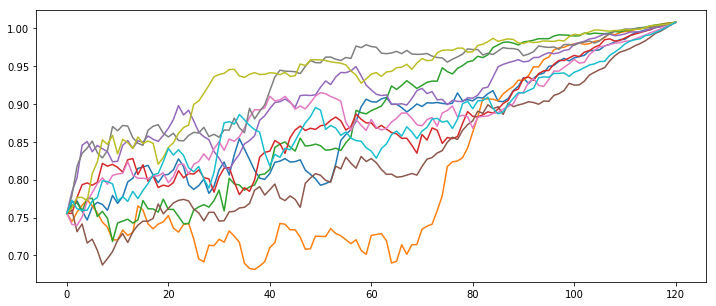

In [19]:
av_zc_bonds.plot(legend=False, figsize=(12,5))

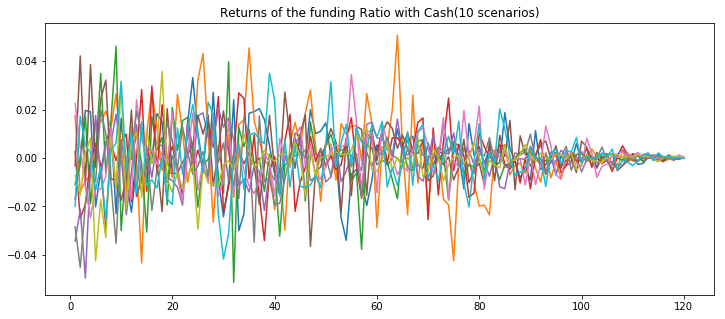

In [20]:
# funding ratio return plot with cash as funding vehicle to hedge liability
(av_cash/liabilities).pct_change().plot(title='Returns of the funding Ratio with Cash(10 scenarios)', legend=False, figsize=(12,5))

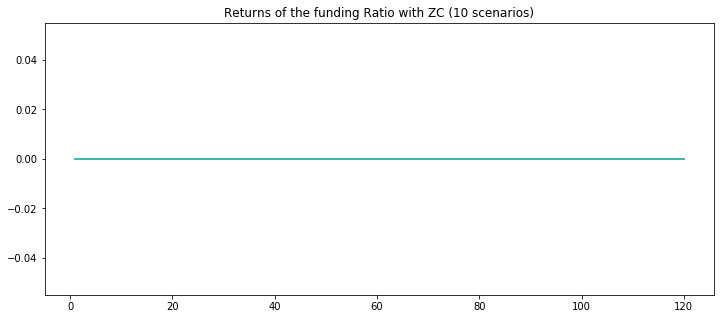

In [21]:
# funding ratio return plot with zero coupon bonds as funding vehicle to hedge liability
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of the funding Ratio with ZC (10 scenarios)', legend=False, figsize=(12,5))

In [22]:
# Use case - Terminal funding ratio
a_0 = .5
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbonsd_10, 0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(1+rates/12).cumprod()

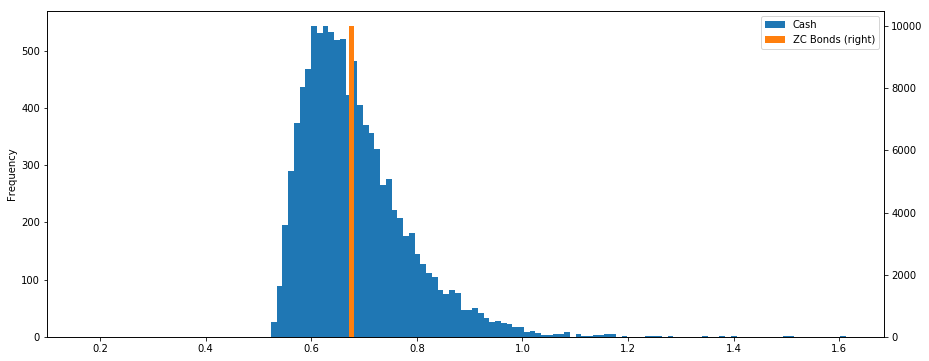

In [98]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label = 'ZC Bonds', bins=100, legend=True, secondary_y=True)

In [102]:
rates, bond_prices = erk.cir(n_scenarios=10000, r_0=0.03, b=0.03)

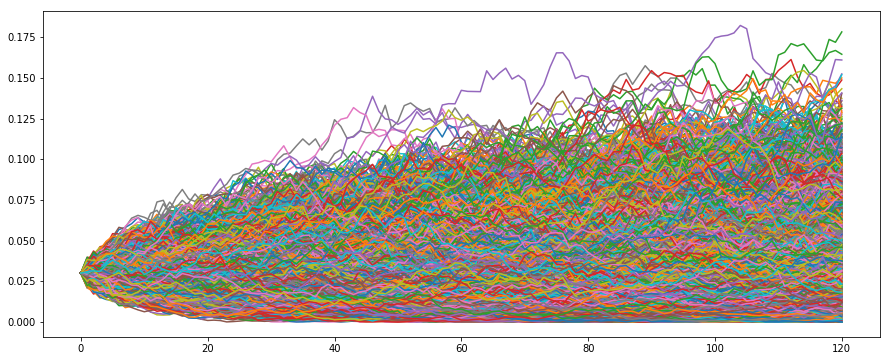

In [103]:
rates.plot(legend=False, figsize=(15,6))